# AVISO data assimilation with correlated error reduction, comparing 1-step and 2-step approach.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, inversion
from aviso_rossby_wave import build_swath, make_error
from aviso_rossby_wave import reverse_vector, make_ssh_predictions

## Starting Date

In [2]:
day0, day1 = 0, 1 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

### Stratification paramters

In [3]:
Phi0 = 45 # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

## Subset 10 degree by 10 degree of ocean

In [4]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [5]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [6]:
T_time = avisso_ds.time.data[day0:] * 86400
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [7]:
ssha_time_mean = SSHA.mean(axis = -1)

In [8]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [9]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [10]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [11]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

### Inversion with selecetd swath data points

In [12]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [13]:
Psi = strat_ds.Psi.data
#Rm = 5.5e4 
#wavespeed = np.array([Rm * f0])
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])


### the aviso data is sampled at 5-day intervals

In [14]:
selected_lat = 0
selected_time = 8 # 5 * 8 = 40 days

#### Rossby wave estimate

In [15]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

#### Rossby deformation radius

In [16]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data
Rm = wave_ds.Rm.data

In [17]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [18]:
MSLA0 = MSLA_fwd[:, :, day0:day1]

In [19]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, Rm, lon, lat, T_time)
M = skill.size
Rm

100%|████████████████████████████████████████| 450/450 [00:01<00:00, 246.13it/s]


array([1.88539712])

In [20]:
kk, ll = np.meshgrid(k_n, l_n)
kk.shape, ll.shape, skill[:, :, 0].shape

((30, 15), (30, 15), (15, 30))

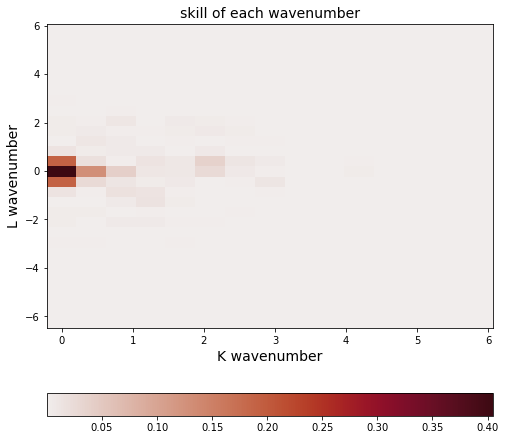

In [21]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0].T, cmap = cmo.cm.amp)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [22]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M*2])
freq_n = np.zeros([M, MModes])

dlon = lon - lon.mean()
dlat = lat - lat.mean()

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1

In [23]:
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk] * dlon[int(Iindex[count])] + l_n[ll] * dlat[int(Jindex[count])] - freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk] * dlon[int(Iindex[count])] + l_n[ll] * dlat[int(Jindex[count])] - freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [24]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### build satellite swath

In [25]:
swath_width, x_swath, day = 6, 20, 1

In [26]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, day, lon, lat)

#### Add errors to the swaths

In [27]:
days = 1 # repeat 

In [28]:
alpha_base = 3e-2 * np.arange(1, days + 1) # baseline dialation error slop
alpha_roll = 5e-2 * np.arange(1, days + 1) # roll error slope
alpha_base, alpha_roll,

(array([0.03]), array([0.05]))

In [29]:
roll_err_valid, baseline_dilation_err_valid, xc1_valid, xc2_valid = make_error(days, alpha_roll, alpha_base, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

#### Add white noise 

In [30]:
N= len(xvalid_index)

In [31]:
MSLA_swath = np.zeros(len(xvalid_index))
nx, ny = len(lon), len(lat)
H_v = np.zeros([N, 2 * M + 2]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    cor_err[ii] = roll_err_valid[ii] + baseline_dilation_err_valid[ii]
    ssh[ii] = MSLA_fwd[ yvalid_index[ii], xvalid_index[ii], tindex[ii]]
    Y_v[ii] = ssh[ii] + cor_err[ii]  + np.random.rand(1)/400 # ~0.25 cm white noise
    H_v[ii, -1] = xc1_valid[ii] #/ xc1_valid.max() # ROLL ERR, distance from nadir Xc !!! Normalized
    H_v[ii, -2] = xc2_valid[ii] #/ xc2_valid.max() # BASELINE DIALATION ERR, distance from nadir Xc !!! Normalized
    for nn in range(M):
        JIndex = 2 * MModes * nn # Model space
        H_v[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_v[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

### 1-step approach: Solve for amplitudes and errors together

#### signal to noise ratio

In [32]:
EXP = 1

In [44]:
P_over_R = np.eye(2 * M + 2, 2 * M + 2)
tmp = np.zeros(2 * M + 2)

for ii in range(2 * M):
    P_over_R[ii, ii] =  1 / 2 / M #* np.abs(amp[ii]) ** EXP
        
P_over_R[-1, -1] = (alpha_roll) ** 2 # roll error
P_over_R[-2, -2] = (alpha_base) ** 2 # baseline dialation error

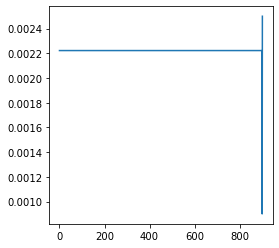

In [45]:
plt.figure(figsize = (4, 4))
plt.plot(P_over_R.diagonal())

In [46]:
amp_1step, ssh_estimated_swath = inversion(Y_v, H_v, P_over_R)

#### True and estimated SSH and Errors

In [47]:
Y_hat = np.matmul(H_v, amp_1step)
err_est = np.matmul(H_v[:, -2:], amp_1step[-2:])
ssh_est = np.matmul(H_v[:, :-2], amp_1step[:-2])

err_map1 = np.zeros([len(lat), len(lon)])
ssh_map1 = np.zeros([len(lat), len(lon)])
ssh_true1 = np.zeros([len(lat), len(lon)])
err_true1 = np.zeros([len(lat), len(lon)])
for ii, idx in enumerate(xvalid_index):
    err_map1[yvalid_index[ii], xvalid_index[ii]] = err_est[ii] #[Iindex[ii].astype(int)]
    ssh_map1[yvalid_index[ii], xvalid_index[ii]]  = ssh_est[ii]
    err_true1[yvalid_index[ii], xvalid_index[ii]] = cor_err[ii]
    ssh_true1[yvalid_index[ii], xvalid_index[ii]] = ssh[ii]

#### Reverse the vectorization on the swaths

In [48]:
ssh_diff1 = np.sqrt(np.mean((ssh_true1 - ssh_map1) ** 2 ))/ np.sqrt(np.mean((ssh_true1) ** 2 ))

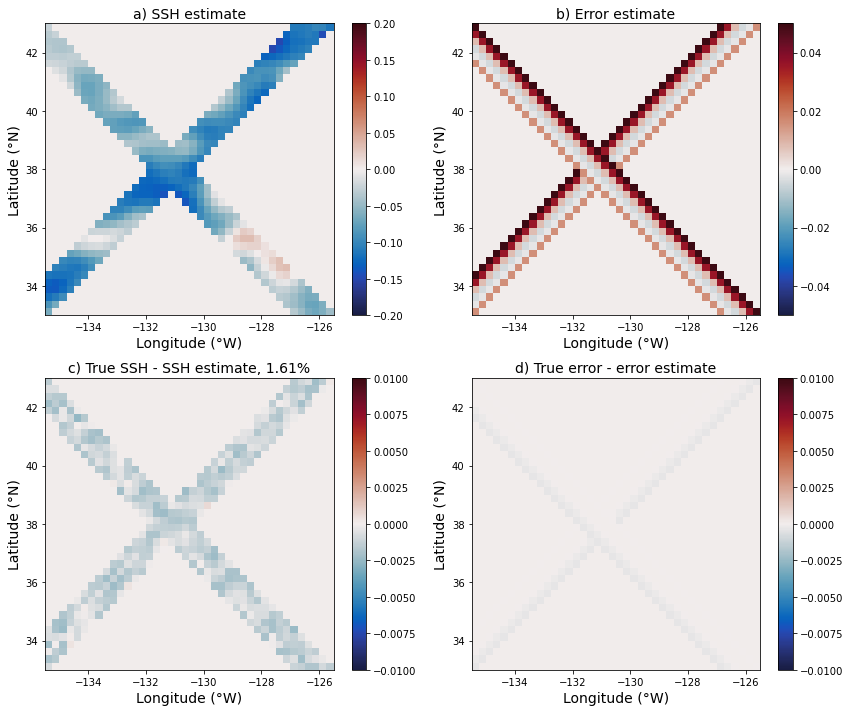

In [49]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map1, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(222)
plt.pcolormesh(lon, lat, err_map1, cmap = cmo.cm.balance, vmin = -.05, vmax = .05)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('b) Error estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true1 - ssh_map1, cmap = cmo.cm.balance, vmin = -.01, vmax = .01)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff1 * 100)[:4] + '%', fontsize = 14)

plt.subplot(224)
plt.pcolormesh(lon, lat, err_true1 - err_map1, cmap = cmo.cm.balance, vmin = -.01, vmax = .01)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('d) True error - error estimate', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+str(date_time[day])[:10] + '_1step.png', dpi = 300)

#### Make predictions of SSH based on the estimated amplitudes:
#### is the extrapolation skill good?

736482.0
736487.0
736492.0
736497.0
736502.0
736507.0
736512.0
736517.0


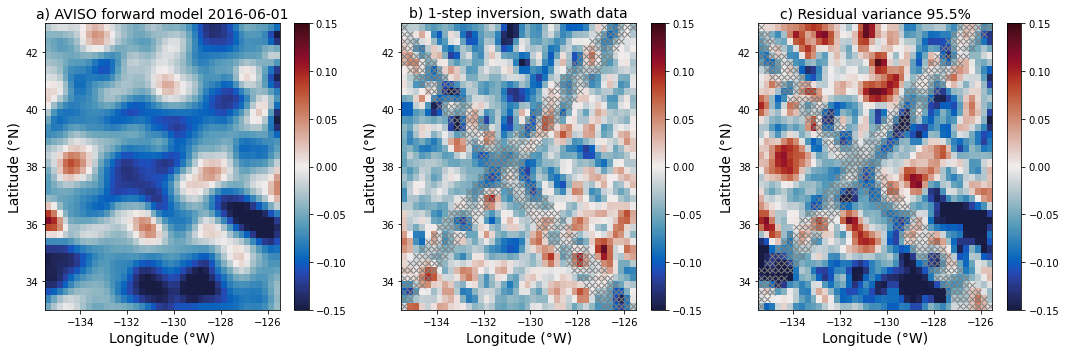

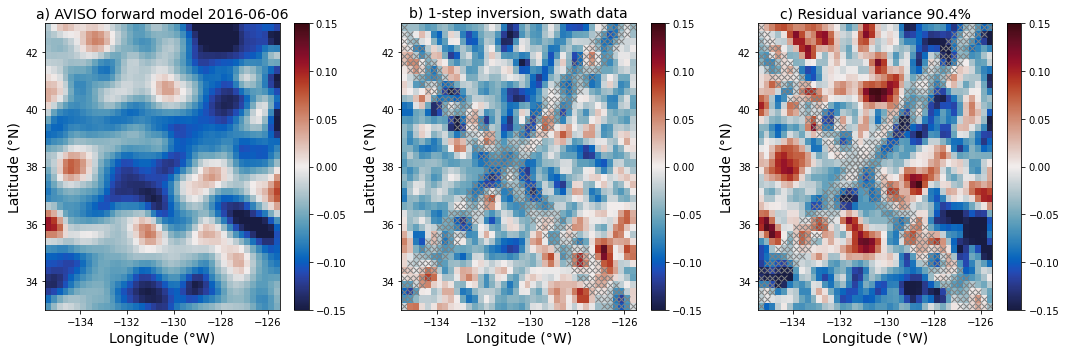

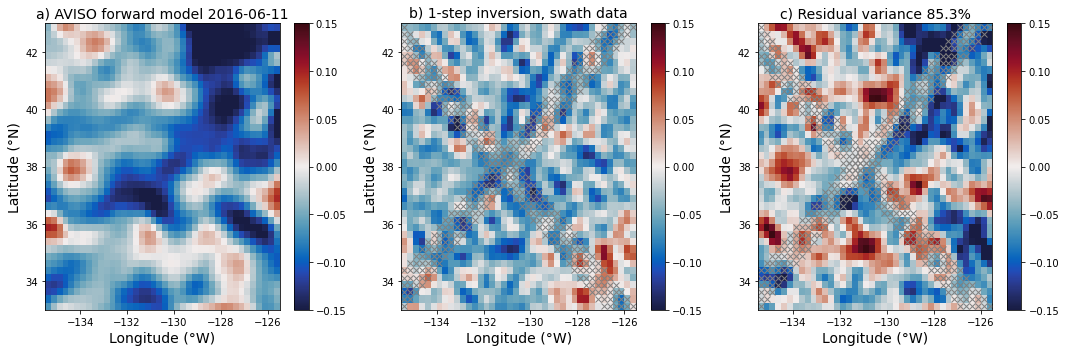

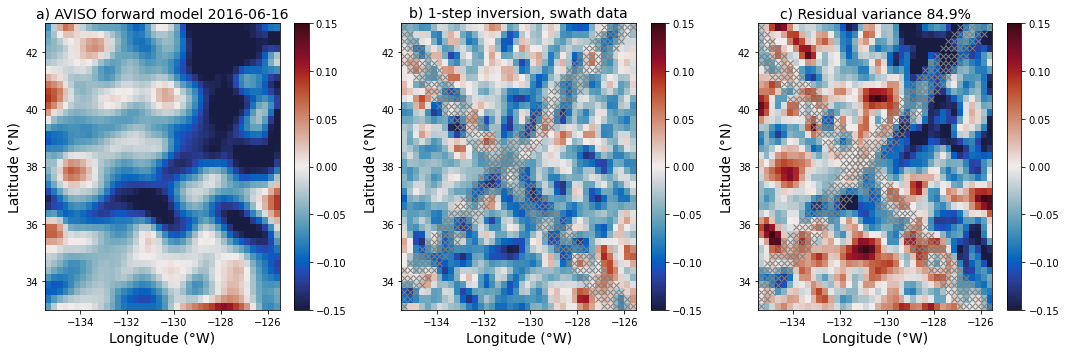

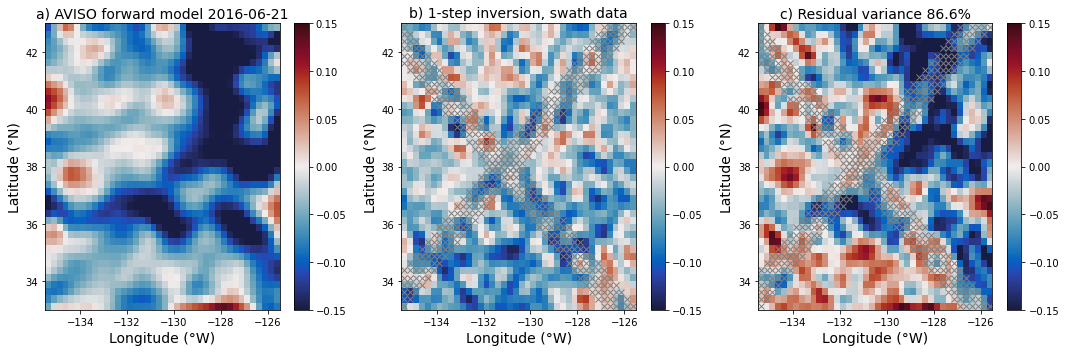

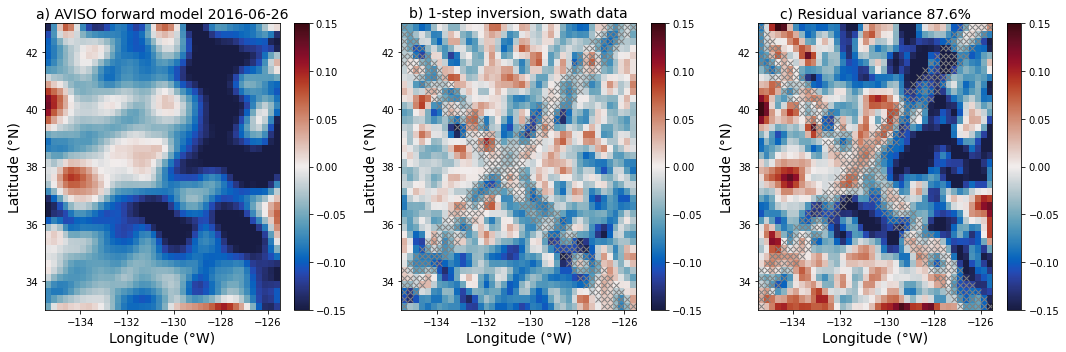

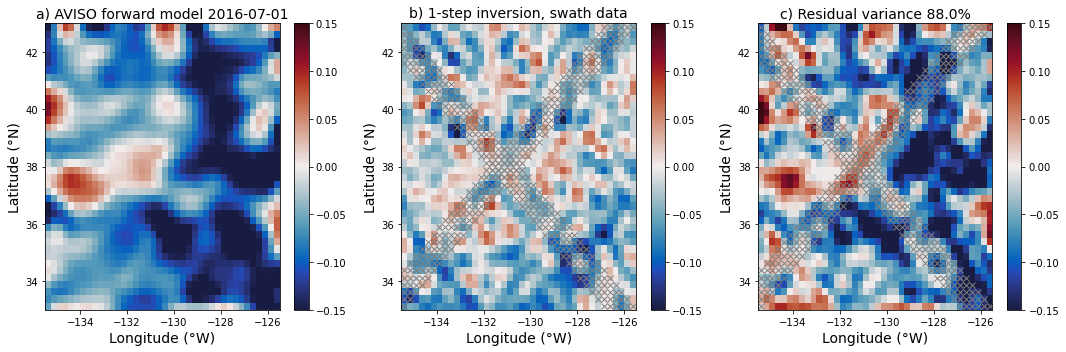

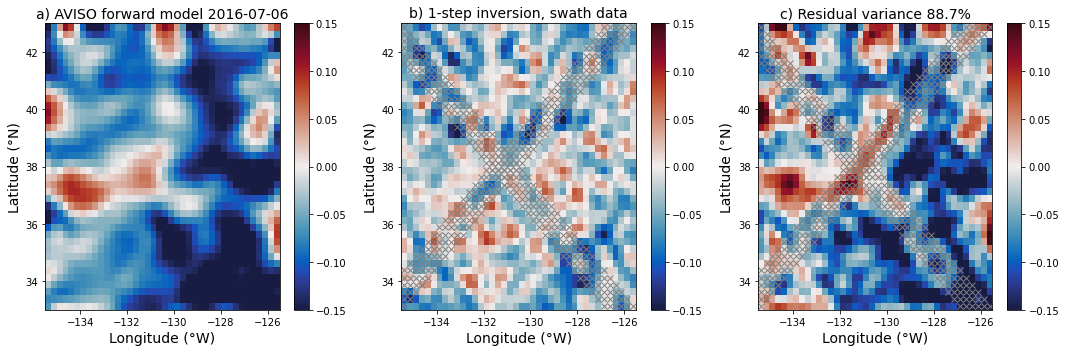

In [51]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0.size])
SSHA_true = np.zeros([time_range, MSLA0.size])
variance_explained_inverse = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range):
    print(T_time[day]/86400)
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = make_ssh_predictions(day, amp_1step[:-2], MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)

    residual = MSLA[:, :, 0] - MSLA_inverse[:, :, day] 
    plt.subplot(133)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('ssh_1step_' + str(date_time[day])[:10] +'_2_err_' + str(skill.size) + 'waves_old.png', dpi = 300)
    